## Determining the optimal threshold

In [1]:
import numpy as np
import mne
import pandas as pd
from itertools import product
import seaborn as sns
import math
import matplotlib.pyplot as plt
from pymatreader import read_mat
from pathlib import Path
from tqdm import tqdm_notebook
import matlab

In [2]:
ab_ica_annots = pd.read_excel('/Users/lina_01/Desktop/ab_ica/AB_ICA_pt_table_opt_thresh_1pt.xlsx')
ab_ica_annots.columns = ['pt', 'channels']
ab_ica_annots = ab_ica_annots.dropna(how='any')
ab_ica_annots.channels =  ab_ica_annots.channels.str.replace("'","").str.split(",")
ab_ica_annots.channels =  [[chan.strip() for chan in chans if chan.strip()] 
                           for chans in ab_ica_annots.channels]

In [3]:
fif_path = Path('/Users/lina_01/Desktop/ab_ica/pt_AB_ICA_raw_files')
annot_path = Path('/Users/lina_01/Desktop/ab_ica')

### Defining functions

In [4]:
def epoch_features(pt): 
    kinds = ['saccade', 'clean']
    #segments = [kind + "_" + channel.lower() for kind, channel in product(kinds, channels)]
    annotations = mne.read_annotations(annot_path / f'manual_annot_AB_ICA_{pt}.csv')
    annotations = pd.DataFrame([annot for annot in annotations if annot['description'] in kinds])
    annotations['offset'] = annotations.onset + annotations.duration
    annotations['kind'] = np.stack(annotations.description)
    #annotations['kind'], annotations['channel'] = np.stack(annotations.description.str.split('_').values).T
    
    return annotations.drop(columns='orig_time')

In [5]:
#Full channel list: ['E1','E8','E14','E17','E21','E25','E32','E125','E126','E127',E128','E11','E62','E75','Cz']
#Excluded channels: E8, E14, E21, E25, E126, E127 
def get_min_max_amplitude(pt, channels):
    rest_raw_processed = mne.io.read_raw_fif(fif_path / f'{pt}_rest_raw_processed.fif', 
                                             verbose=False)
    segment_details = epoch_features(pt)
    segment_details['max_amp'] = [np.max(abs(rest_raw_processed.get_data(picks=channels, 
                                                                     tmin=row.onset, 
                                                                     tmax=row.offset))) 
                                 for _,row in segment_details.iterrows()]
    return segment_details.groupby(['kind']).agg(['min','max'])['max_amp']
    #return segment_details.groupby(['kind', 'channel']).agg(['min','max'])['max_amp']

In [6]:
def mean_error_chan(channel, annotations_df, threshold_labels,  AB_chan_output, 
               rest_raw_processed, kinds = ('saccade', 'clean')):

    mean_errors_all = []
    for kind in kinds:
        onsets = annotations_df.loc[annotations_df['description'] == kind, 'onset']
        offsets = annotations_df.loc[annotations_df['description'] == kind, 'offset']
        
        mean_errors_thresh = []
        for segment_AB in AB_chan_output:
            segment_AB = mne.io.RawArray(segment_AB, rest_raw_processed.info, verbose=False)
            errors = []
            for onset, offset in zip(list(onsets),list(offsets)):
                signal_original = rest_raw_processed.get_data(picks=channel, tmin=onset, tmax=offset)
                signal_AB = segment_AB.get_data(picks=channel, tmin=onset, tmax=offset)
                error = np.mean(abs(signal_original-signal_AB))
                errors.append(error)
            mean_errors_thresh.append(np.mean(errors))
        error_df = pd.DataFrame({'threshold':threshold_labels, 'mean_errors':mean_errors_thresh})
        error_df['kind'] = kind
        error_df['channel'] = channel
        mean_errors_all.append(error_df)
    return pd.concat(mean_errors_all)

### Generating amp_ranges_df

In [7]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    error_dfs = []
    
    amp_ranges = []

    for index, pt in tqdm_notebook(list(ab_ica_annots.pt.items())):
        
        rest_raw_processed = mne.io.read_raw_fif(fif_path / f'{pt}_rest_raw_processed.fif',
                                                verbose=False)
        annotations_df = epoch_features(pt)
        
        for chan in ab_ica_annots.loc[index, 'channels']:
            amplitude_range = get_min_max_amplitude(pt, chan)
            amplitude_range = pd.DataFrame({'min_amp': [int(np.floor(amplitude_range['min'].min()*1e6))], 
                                            'max_amp': [int(np.ceil(amplitude_range['max'].max()*1e6))]})
            amplitude_range['chan'] = chan
            amplitude_range['pt'] = pt
            amp_ranges.append(amplitude_range)
       
    amp_ranges_df = pd.concat(amp_ranges).set_index(['pt', 'chan'])

  0%|          | 0/1 [00:00<?, ?it/s]

### Generating error df

In [8]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    error_dfs = []

    for index, pt in tqdm_notebook(list(ab_ica_annots.pt.items())):
        
        rest_raw_processed = mne.io.read_raw_fif(fif_path / f'{pt}_rest_raw_processed.fif',
                                                verbose=False)
        annotations_df = epoch_features(pt)
        
        s_m12_AB_mat_outdata = read_mat(fif_path / f'{pt}_threshoutputs_orig.mat')
        overall_threshold_labels = np.arange(amp_ranges_df.loc[pt, 'min_amp'].min(), 
                                             amp_ranges_df.loc[pt, 'max_amp'].max() + 1)
        for chan in ab_ica_annots.loc[index, 'channels']:
            threshold_labels = np.arange(amp_ranges_df.loc[(pt, chan), 'min_amp'],
                                         amp_ranges_df.loc[(pt, chan), 'max_amp']+1)
            mask = np.in1d(overall_threshold_labels, threshold_labels)
            start, stop = np.where(mask)[0][[0, -1]]
            AB_chan_output = s_m12_AB_mat_outdata['thresh_outputs']['OutData'][start:stop+1]
            error_df = mean_error_chan(chan, annotations_df, threshold_labels,  AB_chan_output,
                                       rest_raw_processed)
            error_df['pt'] = pt
            error_dfs.append(error_df)
    error_df = pd.concat(error_dfs).set_index(['pt', 'channel'])

  0%|          | 0/1 [00:00<?, ?it/s]

### Calculating optimal threshold

In [9]:
total_errors = []
optimal_thresholds = []
for index, pt in ab_ica_annots.pt.items():
    error_df_slice_pt = error_df.loc[pt]
    for chan in error_df_slice_pt.index.unique():
        error_df_slice = error_df_slice_pt.loc[chan]
        error_df_slice.loc[:, 'mean_errors_normalized'] = error_df_slice.loc[:, 'mean_errors']
        for kind in error_df_slice['kind'].unique():
            mask = error_df_slice.kind==kind
            error_df_slice.loc[mask, 'mean_errors_normalized'] -= error_df_slice.loc[mask, 'mean_errors_normalized'].min()
            error_df_slice.loc[mask, 'mean_errors_normalized'] /= error_df_slice.loc[mask, 'mean_errors_normalized'].max()

        total_error = (1 - error_df_slice[error_df_slice.kind=='saccade'].set_index('threshold').mean_errors_normalized 
                         + error_df_slice[error_df_slice.kind=='clean'].set_index('threshold').mean_errors_normalized)
        total_error = total_error.to_frame()
        total_error['pt'] = pt
        total_error['channel'] = chan
        total_errors.append(total_error)

        optimal_threshold = pd.DataFrame({'optimal_threshold': [total_error.mean_errors_normalized.idxmin()], 
                                          'channel':[chan]})
        optimal_threshold['pt'] = pt
        optimal_thresholds.append(optimal_threshold)
total_errors = pd.concat(total_errors)
optimal_thresholds = pd.concat(optimal_thresholds)

/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1505/1961300605.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df_slice.loc[:, 'mean_errors_normalized'] = error_df_slice.loc[:, 'mean_errors']
/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1505/1961300605.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df_slice.loc[:, 'mean_errors_normalized'] = error_df_slice.loc[:, 'mean_errors']
/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1505/1961300605.py:7: Set

In [10]:
opt_threshes = {}
for pt in ab_ica_annots.pt.unique():
    optimal_thresholds_slice = optimal_thresholds.loc[optimal_thresholds['pt'] == pt]
    opt_thresh = optimal_thresholds_slice['optimal_threshold'].mean()
    opt_threshes[pt] = opt_thresh

In [11]:
opt_threshes

{'s058_m12': 19.533333333333335}

### Plots

In [18]:
error_df = error_df.reset_index()

In [19]:
error_df.loc[:, 'mean_errors_normalized'] = error_df.loc[:, 'mean_errors']

In [20]:
error_df_slice = error_df.loc[error_df['channel']=='E1']

In [21]:
error_df_slices = []
for kind in error_df_slice['kind'].unique():
    mask = error_df_slice.kind==kind
    error_df_slice.loc[mask, 'mean_errors_normalized'] -= error_df_slice.loc[mask, 'mean_errors_normalized'].min()
    error_df_slice.loc[mask, 'mean_errors_normalized'] /= error_df_slice.loc[mask, 'mean_errors_normalized'].max()
    error_df_slices.append(error_df_slice)

In [22]:
error_df_slices = pd.concat(error_df_slices)

In [23]:
total_errors = total_errors.reset_index()

In [24]:
total_error_slice = total_errors.loc[total_errors['channel']=='E1']

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

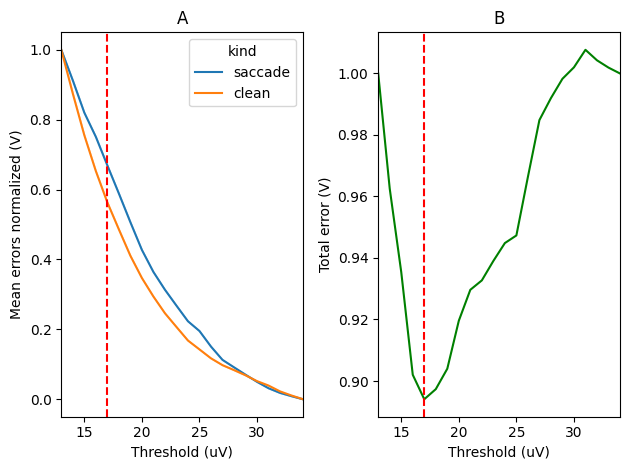

In [25]:
fig, axes = plt.subplots(1,2)

g = sns.lineplot(data = error_df_slices, x='threshold', y='mean_errors_normalized', hue='kind',ax=axes[0])
g.axes.axvline(x = 17, linestyle='dashed', color='red')
g.set_xlabel('Threshold (uV)',fontsize=10)
g.set_ylabel('Mean errors normalized (V)',fontsize=10)
g.set_title('A')
g.set_xlim(13,34)

g = sns.lineplot(data = total_error_slice, x='threshold', y='mean_errors_normalized',color='green',ax=axes[1])
g.axes.axvline(x = 17, linestyle='dashed', color='red')
g.set_xlabel('Threshold (uV)',fontsize=10)
g.set_ylabel('Total error (V)',fontsize=10)
g.set_title('B')
g.set_xlim(13,34)

fig.tight_layout()

In [26]:
fig.savefig('fig2.png',dpi=300)

### 2.5 AB_output_generation

In [ ]:
fif_path = Path('/Users/lina_01/Downloads/fieldtrip-20220208')
annot_path = Path('C:/Users/dsrish/Desktop/ds_msc_project')

ab_output_df = pd.read_excel(annot_path / 'AB_ICA_pt_selection.xlsx')

code = """
disp(pt)

fiff_file = [pt,'_rest_raw_processed.fif']
cfg = [];
cfg.dataset = fiff_file;
data1 = ft_preprocessing(cfg)

cfg = [];
cfg.Approach = 'Window';
cfg.Threshold = (opt_thresh).*1e-06; %voltage threshold
cfg.Fs = data1.fsample;
cfg.WindowSize = 1; %unit in second
cfg.InData = data1.trial{1}; %may have to exclude the high-pass artifact before AB %ONE TRIAL ONLY
cfg = Run_AB(cfg);
data1.trial{1} = [cfg.OutData]; 

%Saving to export to MNE
datatosave_in = rmfield(cfg, setdiff(fieldnames(cfg), {'InData'}))
datatosave_out = rmfield(cfg, setdiff(fieldnames(cfg), {'OutData'}))

filename = [pt, '_AB_outdata.mat']
save(filename, 'datatosave_out')"""

import matlab.engine
import io

for pt in ab_output_df.pt.unique():
    out = io.StringIO()
    err = io.StringIO()
    eng = matlab.engine.start_matlab()
    eng.workspace['pt'] = pt
    mask = ab_output_df.pt == pt
    eng.workspace['opt_thresh'] = float(ab_output_df.loc[mask, 'opt_thresh'])
    out.truncate(0)
    out.seek(0)
    err.truncate(0)
    err.seek(0)
    eng.eval(code, nargout=0, stdout=out, stderr=err)
    print(out.getvalue())
    print(err.getvalue())

##test##

code = """
disp(pt)

fiff_file = /Users/lina_01/Downloads/pt_AB_ICA_raw_files/s058_m12_rest_raw_processed.fif
cfg = [];
cfg.dataset = fiff_file;
data1 = ft_preprocessing(cfg)

cfg = [];
cfg.Approach = 'Window';
cfg.Threshold = 19.53*1e-06; %voltage threshold
cfg.Fs = data1.fsample;
cfg.WindowSize = 1; %unit in second
cfg.InData = data1.trial{1}; %may have to exclude the high-pass artifact before AB %ONE TRIAL ONLY
cfg = Run_AB(cfg);
data1.trial{1} = [cfg.OutData]; 

%Saving to export to MNE
datatosave_in = rmfield(cfg, setdiff(fieldnames(cfg), {'InData'}))
datatosave_out = rmfield(cfg, setdiff(fieldnames(cfg), {'OutData'}))

filename = ['s058_m12', '_AB_outdata.mat']
save(filename, 'datatosave_out')"""